# import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [5]:
data = pd.read_csv("insurance.csv")

In [6]:
import pandas as pd

In [7]:
type(data)

pandas.core.frame.DataFrame

In [8]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [5]:
output_var = 'charges'

#### Data Exploration
In this section we vizualise the data using univariate and bi-variate plots and simple descriptive statistics. We first split the data into a training and test data set and only vizualise the training set to simulate the fact that we do not want to draw any conclusions based on the test data that is only to be used to measure the expected accuracy of the model on previously unseen (out of sample) data.

In [6]:
import numpy as np
X = data[data.columns[~data.columns.isin([output_var])]]
y = data[[output_var]]

from sklearn.model_selection import train_test_split
np.random.seed(37) # Set seed
x_train, x_test = train_test_split(X, test_size = 0.25)

## dont using iloc as we have projected from data
y_train = y.loc[x_train.index.values] 
y_test = y.loc[x_test.index.values]
x_train = X.loc[x_train.index.values, :]
x_test = X.loc[x_test.index.values, :]

In [7]:
x_train.shape, x_test.shape

((1003, 6), (335, 6))

In [8]:
concat_train_data = pd.concat([x_train,y_train],axis=1)

In [9]:
concat_train_data.describe()

,age,bmi,children,charges
count,1003.000000,1003.000000,1003.000000,1003.000000
mean,39.437687,30.630189,1.101695,13524.816768
std,14.171492,6.230134,1.224185,12416.940908
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.050000,0.000000,4759.829400
50%,40.000000,30.210000,1.000000,9391.346000
75%,51.000000,34.800000,2.000000,17062.210700
max,64.000000,53.130000,5.000000,63770.428010


###### Note:
<li>A baseline model is when we predict charges for all customers as the average (mean) charges in the training data. The Root Mean Square Error is the standard deviation which we can see above is \$12,416.94
<li> Charges has a skewed distribution, the mean is much larger than the meadian value, suggesting that they are people with large values of charges that is affecting the mean value.

In [10]:
concat_train_data.corr()[output_var].sort_values()

children    0.064900
bmi         0.224817
age         0.302320
charges     1.000000
Name: charges, dtype: float64

In [11]:
concat_train_data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [12]:
concat_train_data.query('region=="northwest"').describe()

,age,bmi,children,charges
count,240.000000,240.000000,240.000000,240.000000
mean,39.220833,29.259604,1.183333,12881.882492
std,14.041972,5.281592,1.182037,11672.758792
min,19.000000,17.385000,0.000000,1621.340200
25%,26.000000,25.816250,0.000000,4606.413187
50%,39.000000,28.832500,1.000000,8883.099750
75%,51.000000,32.775000,2.000000,16452.097987
max,64.000000,42.940000,5.000000,60021.398970


### Bi-variate Analysis

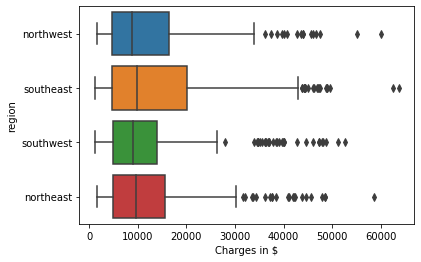

In [13]:
import seaborn as sns
sns.boxplot(y='region',x=output_var,data=concat_train_data,orient='h')
plt.xlabel("Charges in $")
plt.show()

Question: If the whiskers on the box plot are supposed to be of length 1.5\*IQR, why do they appear to be of different length? 

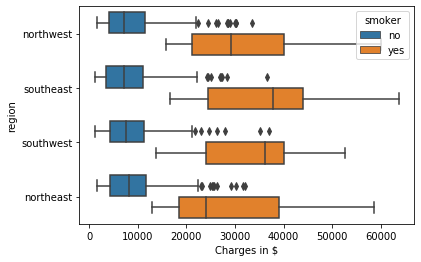

In [14]:
sns.boxplot(y='region',x='charges',data=concat_train_data,hue='smoker',orient='h')
plt.xlabel("Charges in $")
plt.show()

###### Note: 
We can see from the box plots above that smoking results in a significant increase in insurance charges. In addition to being higher, it also seems like there is a larger variance in Charges for smokers. Hence outliers only appear in non-smoker where the variance seems much smaller. Also not that smokers are paying a lot more in southeast and southwest compared with the north. However, for non smokers, the northeast appear most expensive.

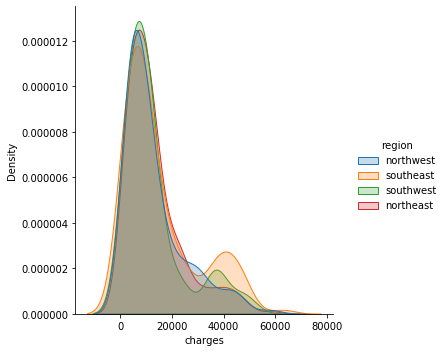

In [15]:
sns.displot(concat_train_data, x=output_var, hue="region", kind="kde", fill=True)

###### Note:
All distributions around region are similar, bi-model distributions. We can hypothesise that the two modes are associated with smokers and non-smokers. The increase in charges seems most pronounced for the south east and south west, which can be inferred from the box plots above too.

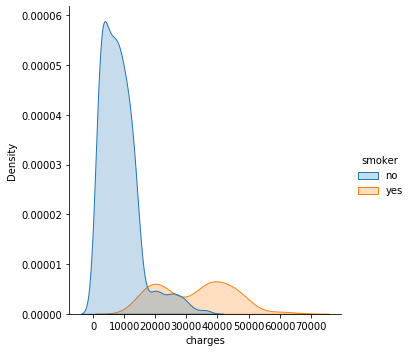

In [16]:
sns.displot(concat_train_data, x=output_var, hue="smoker", kind="kde", fill=True)

In [17]:
from scipy.stats import ttest_ind
cat1 = concat_train_data.query("smoker=='yes'")
cat2 = concat_train_data.query("smoker=='no'")

ttest_ind(cat1['charges'], cat2['charges'])

Ttest_indResult(statistic=40.467990095450745, pvalue=6.605777632369158e-213)

In [18]:
cat1 = concat_train_data.query("region=='northeast'")
cat2 = concat_train_data.query("region=='northwest'")

ttest_ind(cat1['charges'], cat2['charges'])

Ttest_indResult(statistic=0.06309282994940242, pvalue=0.9497186850232642)

In [19]:
## Anova
# Th p-value greater than 0.05 suggest that there are no significant differences in insurance charges based on region
import scipy.stats as stats
keys = np.unique(concat_train_data['region'])
data_charges = []
for key in keys:
    data_charges.append(concat_train_data.query("region=='"+key+"'")['charges'])
    
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(data_charges[0],data_charges[1],data_charges[2],data_charges[3])
print(fvalue, pvalue)

2.334817214477955 0.07242554384315687


In [20]:
# regions have equal variance (Null Hypothesis not rejected as p > 0.05) - Assuming data generated fromnormal distribution

import scipy.stats as stats
w, pvalue = stats.bartlett(data_charges[0],data_charges[1],data_charges[2],data_charges[3])
print(w, pvalue)

# if you have a stacked table, you can use bioinfokit v1.0.3 or later for the bartlett's test
from bioinfokit.analys import stat 
res = stat()
res.bartlett(df=df_melt, res_var='value', xfac_var='treatments')
res.bartlett_summary

20.48459824450081 0.00013468204139095664


NameError: name 'df_melt' is not defined

In [22]:
# regions do not have equal variance (Null Hypothesis rejected as p < 0.05) - Assuming data not generated from 
# normal distribution

from bioinfokit.analys import stat 
res = stat()
res.levene(df=concat_train_data, res_var='charges', xfac_var='region')
res.levene_summary

,Parameter,Value
0,Test statistics (W),4.2106
1,Degrees of freedom (Df),3.0000
2,p value,0.0057


In [23]:
## Anova
# Th p-value less than 0.05 suggest that there are significant differences in insurance charges based on region for Smokers
keys = np.unique(concat_train_data.query("smoker=='yes'")['region'])
data_charges = []
for key in keys:
    data_charges.append(concat_train_data.query("smoker=='yes'").query("region=='"+key+"'")['charges'])
    
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(data_charges[0],data_charges[1],data_charges[2],data_charges[3])
print(fvalue, pvalue)

3.801458794666325 0.011080587767858205


In [24]:
# regions have equal variance (Null Hypothesis not rejected as p > 0.05) - Assuming data generated from normal distribution

import scipy.stats as stats
w, pvalue = stats.bartlett(data_charges[0],data_charges[1],data_charges[2],data_charges[3])
print(w, pvalue)

# if you have a stacked table, you can use bioinfokit v1.0.3 or later for the bartlett's test
from bioinfokit.analys import stat 
res = stat()
res.bartlett(df=df_melt, res_var='value', xfac_var='treatments')
res.bartlett_summary

0.499541554334887 0.9189921186209804


NameError: name 'df_melt' is not defined

In [25]:
# regions have equal variance (Null Hypothesis not rejected as p > 0.05) - Assuming data not generated from 
# normal distribution

from bioinfokit.analys import stat 
res = stat()
res.levene(df=concat_train_data.query("smoker=='yes'"), res_var='charges', xfac_var='region')
res.levene_summary

,Parameter,Value
0,Test statistics (W),0.5682
1,Degrees of freedom (Df),3.0000
2,p value,0.6366


In [26]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('charges ~ C(region)', data=concat_train_data.query("smoker=='yes'")).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(region),1.512522e+09,3.0,3.801459,0.011081
Residual,2.692316e+10,203.0,NaN,NaN


In [27]:
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)
# Mote: as the p-value < 0.05 we reject the null hyothesis that the residuals are Normally distributed

0.9632441401481628 3.2851967262104154e-05


In [28]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=concat_train_data.query("smoker=='yes'"), res_var='charges', xfac_var='region', anova_model='charges ~ C(region)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,southeast,northeast,6830.767516,1255.899145,12405.635887,4.488961,0.009337
1,southeast,northwest,4450.102232,-1234.557752,10134.762215,2.867982,0.181109
2,southeast,southwest,1664.462223,-4100.546297,7429.470743,1.057755,0.865568
3,northeast,northwest,2380.665284,-3809.831875,8571.162444,1.408911,0.726575
4,northeast,southwest,5166.305293,-1098.055743,11430.666330,3.021441,0.145106
5,northwest,southwest,2785.640009,-3576.625387,9147.905405,1.604073,0.649327


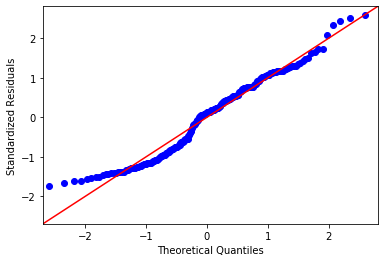

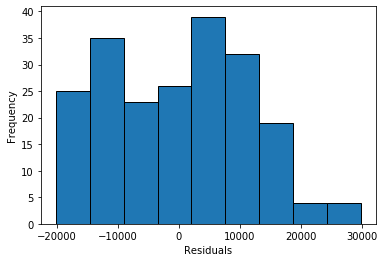

In [29]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [30]:
# load packages
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Ordinary Least Squares (OLS) model
# C(Genotype):C(years) represent interaction term
model = ols('charges ~ C(smoker) + C(region) + C(smoker):C(region)', data=concat_train_data).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
print(anova_table)

                           sum_sq     df           F        PR(>F)
Intercept            1.628873e+10    1.0  284.426366  2.539827e-56
C(smoker)            1.493473e+10    1.0  260.783446  2.815030e-52
C(region)            1.119060e+08    3.0    0.651351  5.821945e-01
C(smoker):C(region)  1.538280e+09    3.0    8.953584  7.429591e-06
Residual             5.698236e+10  995.0         NaN           NaN


In [31]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
# for main effect Genotype
res.tukey_hsd(df=concat_train_data, res_var='charges', xfac_var='smoker', anova_model='charges ~ C(smoker) + C(region) + C(smoker):C(region)')
print(res.tukey_summary)

# for main effect years
res.tukey_hsd(df=concat_train_data, res_var='charges', xfac_var='region', anova_model='charges ~ C(smoker) + C(region) + C(smoker):C(region)')
print(res.tukey_summary)

# for interaction effect between genotype and years
res.tukey_hsd(df=concat_train_data, res_var='charges', xfac_var=['region','smoker'], anova_model='charges ~ C(smoker) + C(region) + C(smoker):C(region)')
print(res.tukey_summary)

  group1 group2          Diff         Lower         Upper    q-value  p-value
0     no    yes  24158.907976  23000.279715  25317.536237  57.866189    0.001
      group1     group2         Diff        Lower        Upper   q-value  \
0  northwest  southeast  2326.702423   606.427704  4046.977141  4.922271   
1  northwest  southwest    44.987921 -1727.286494  1817.262336  0.092382   
2  northwest  northeast    65.110113 -1703.566228  1833.786454  0.133975   
3  southeast  southwest  2371.690344   657.095330  4086.285357  5.034066   
4  southeast  northeast  2261.592310   550.716669  3972.467951  4.810812   
5  southwest  northeast   110.098034 -1653.054527  1873.250595  0.227254   

    p-value  
0  0.002929  
1  0.900000  
2  0.900000  
3  0.002199  
4  0.003881  
5  0.900000  
              group1            group2          Diff         Lower  \
0    (northwest, no)  (northwest, yes)  22477.441662  18676.119460   
1    (northwest, no)   (southeast, no)    554.016493  -1747.990732   
2  

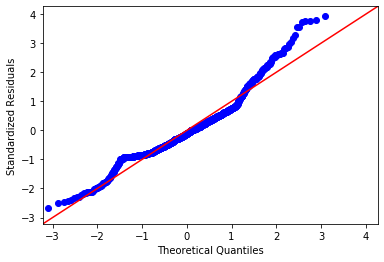

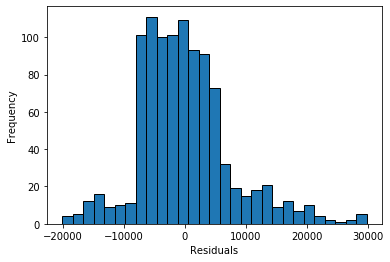

0.9514802694320679 1.12894056678768e-17


In [32]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from two-way ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

# Shapiro-Wilk test
import scipy.stats as stats
w, pvalue = stats.shapiro(res.anova_model_out.resid)
print(w, pvalue)

KeyError: 0

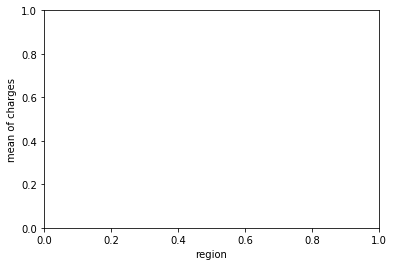

In [33]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(x=concat_train_data.region, trace=concat_train_data.smoker, response=concat_train_data.charges, 
                       colors=['red','blue'])
plt.show()

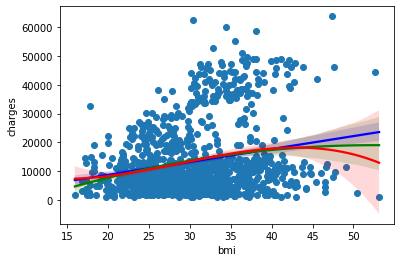

In [34]:
i_attribute = 'bmi'
plt.scatter(x=concat_train_data[i_attribute],y=concat_train_data['charges'])
sns.regplot(x=i_attribute,y='charges', data=concat_train_data,  scatter=None, color='b', order=1)
sns.regplot(x=i_attribute,y='charges', data=concat_train_data,  scatter=None, color='g', order=2)
sns.regplot(x=i_attribute,y='charges', data=concat_train_data,  scatter=None, color='r', order=3)
plt.show()

C:\Users\sarab\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sarab\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\sarab\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\sarab\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

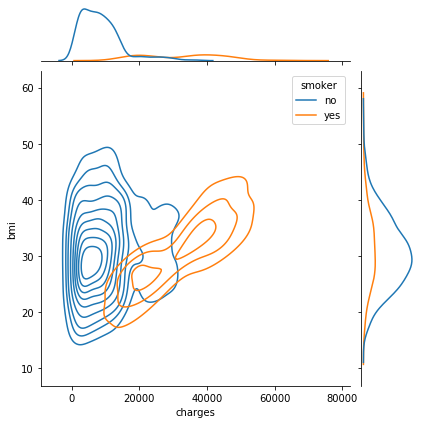

In [35]:
sns.jointplot(x="charges",y="bmi",hue='smoker',data=concat_train_data,kind='kde')
plt.xlabel("Charges in $")
plt.ylabel("bmi")
plt.show()

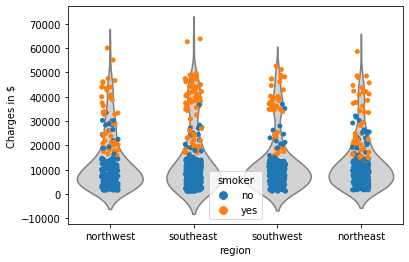

In [36]:
sns.violinplot(x='region',y='charges',data=concat_train_data,inner=None,color='lightgray')
sns.stripplot(x='region',y='charges',data=concat_train_data,size=5,hue='smoker',jitter=True)
plt.ylabel("Charges in $")
plt.show()

In [37]:
from scipy.stats import chi2_contingency
cross_data = pd.crosstab(concat_train_data.region, concat_train_data.smoker)
stat, p, dof, expected = chi2_contingency(cross_data) 
print(cross_data)
print(stat,p)

smoker      no  yes
region             
northeast  197   48
northwest  195   45
southeast  204   71
southwest  200   43
6.476103468620635 0.09060970308933447


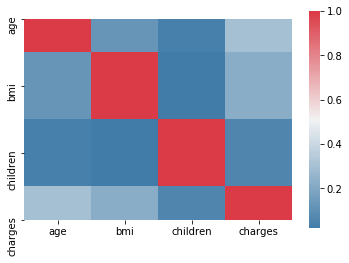

In [38]:
corr = concat_train_data.corr()
import seaborn as sns
import numpy as np
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True)

In [39]:
corr

,age,bmi,children,charges
age,1.000000,0.126539,0.035514,0.302320
bmi,0.126539,1.000000,0.019980,0.224817
children,0.035514,0.019980,1.000000,0.064900
charges,0.302320,0.224817,0.064900,1.000000


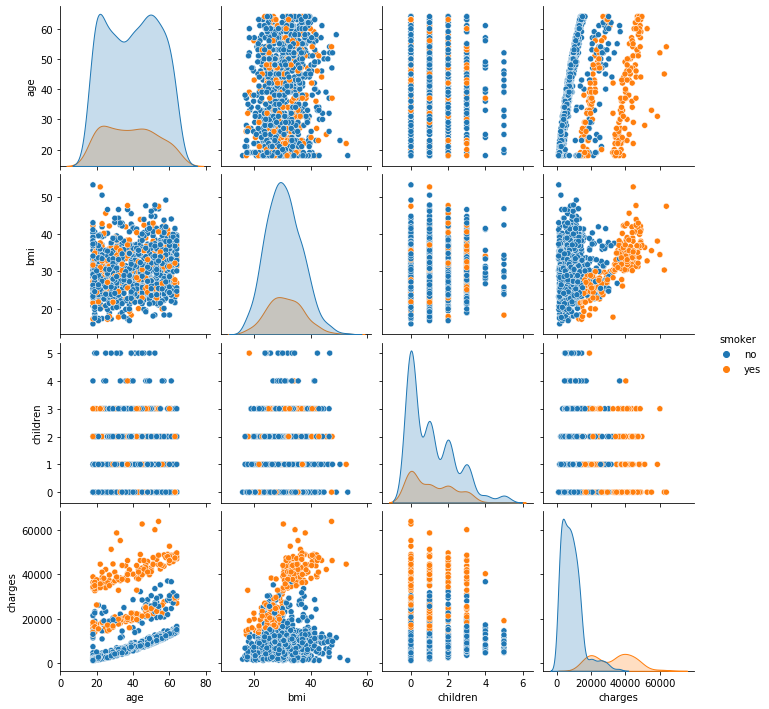

In [40]:
sns.pairplot(concat_train_data, hue="smoker", height=2.5)

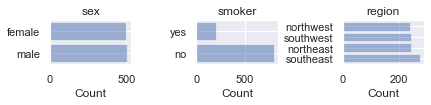

In [41]:
sns.set(rc={'figure.figsize':(6.7,2.27)})
fig = plt.figure()
fig.subplots_adjust(hspace=0.8, wspace=0.8)
attr = ['sex','smoker','region']
for i in range(0,3):
    ax = fig.add_subplot(2, 3, i+1)
    counts = concat_train_data[attr[i]].value_counts()
    myproblems = list(counts.index)
    my_problem_counts = list(counts)
    y_pos = np.arange(len(myproblems))
    plt.barh(y_pos, my_problem_counts, align='center', alpha=0.5)
    plt.yticks(y_pos, myproblems)
    plt.xlabel('Count')
    plt.title(attr[i])

## Create Dummy Variables

In [42]:
encoded_data = pd.get_dummies(concat_train_data, columns=["sex","smoker","region"],drop_first=True)
encoded_data.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
769,38,19.475,2,6933.24225,0,0,1,0,0
803,18,42.240,0,38792.68560,0,1,0,1,0
1062,59,41.140,1,48970.24760,1,1,0,1,0
973,19,40.500,0,1759.33800,0,0,0,0,1
452,24,23.400,0,1969.61400,1,0,0,0,1


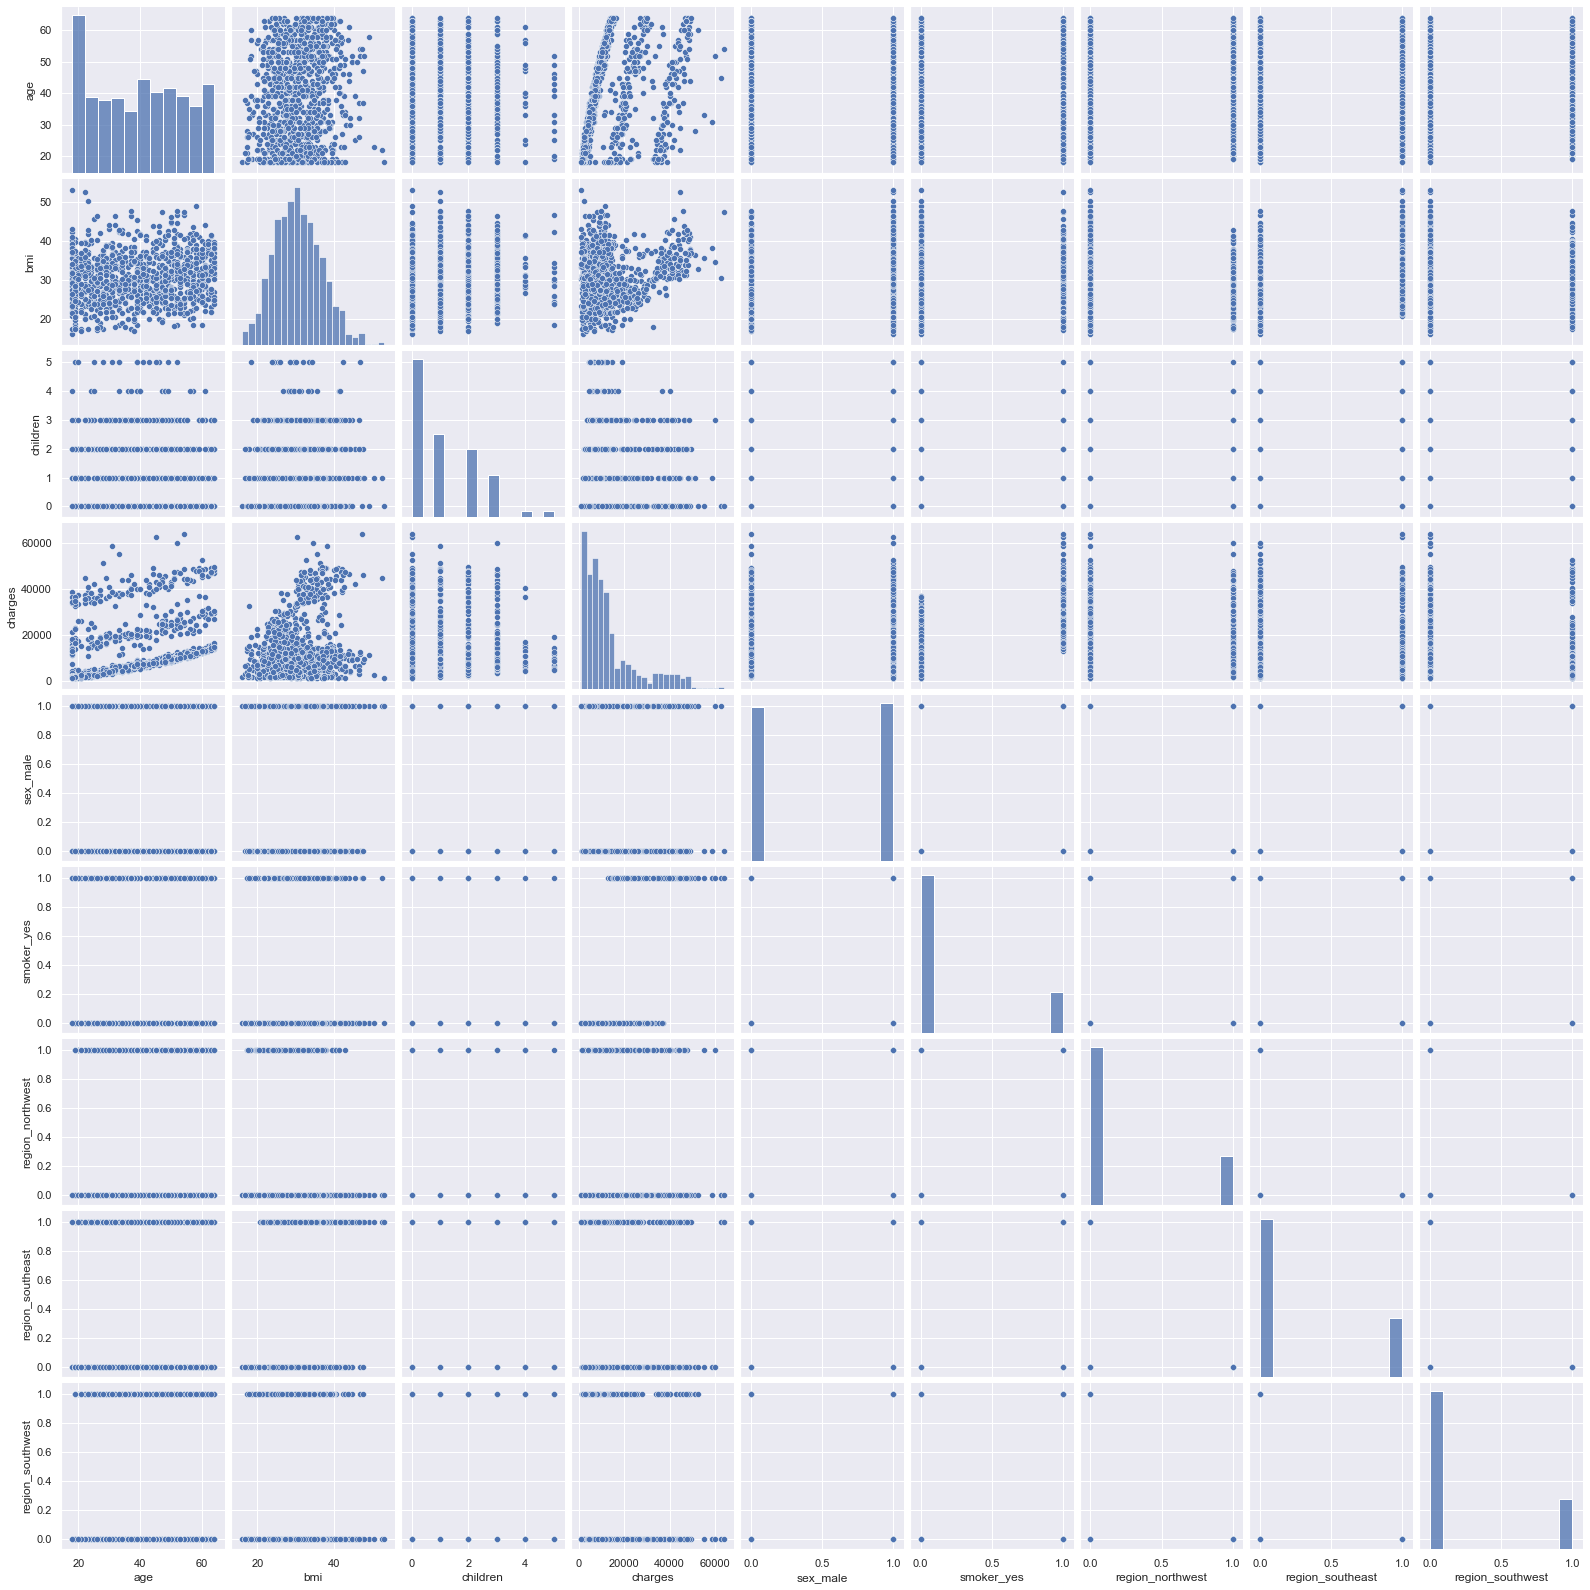

In [43]:
sns.pairplot(encoded_data, height=2.5)

## Building Models

In [44]:
encoded_data.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
769,38,19.475,2,6933.24225,0,0,1,0,0
803,18,42.240,0,38792.68560,0,1,0,1,0
1062,59,41.140,1,48970.24760,1,1,0,1,0
973,19,40.500,0,1759.33800,0,0,0,0,1
452,24,23.400,0,1969.61400,1,0,0,0,1


In [45]:
# from sklearn import datasets, linear_model
# from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = encoded_data[encoded_data.columns[~encoded_data.columns.isin([output_var])]].to_numpy()
y = encoded_data[[output_var]].to_numpy()

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     388.2
Date:                Fri, 12 Feb 2021   Prob (F-statistic):          1.31e-299
Time:                        19:21:48   Log-Likelihood:                -10167.
No. Observations:                1003   AIC:                         2.035e+04
Df Residuals:                     994   BIC:                         2.040e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.235e+04   1122.804    -11.001      0.0

### The Impact of Min Max Transform on Regression Coefficients 

In [46]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(encoded_data[encoded_data.columns[~encoded_data.columns.isin([output_var])]])
Y = encoded_data[[output_var]]

In [47]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     388.2
Date:                Fri, 12 Feb 2021   Prob (F-statistic):          1.31e-299
Time:                        19:21:48   Log-Likelihood:                -10167.
No. Observations:                1003   AIC:                         2.035e+04
Df Residuals:                     994   BIC:                         2.040e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2143.0093    667.574     -3.210      0.0

In [48]:
inputs = list(encoded_data.columns)
inputs.remove(output_var)
print(inputs)

['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']


#### Make Predictions

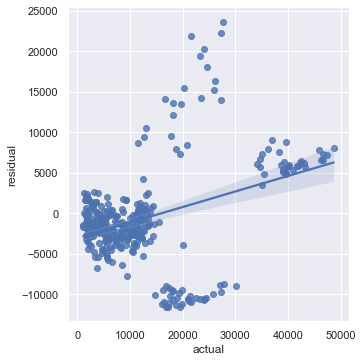

Root Mean Square Error:  5867.444476680466


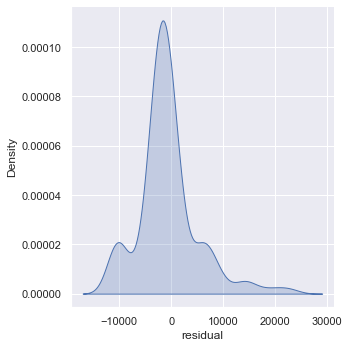

In [49]:
X_test = scaler.transform(pd.get_dummies(x_test, columns=["sex","smoker","region"],drop_first=True))
X_test = pd.DataFrame(X_test,columns = inputs)
y_pred = est2.predict(sm.add_constant(X_test))
preds = y_pred.to_numpy().reshape(len(y_pred),1)
residual_df = pd.DataFrame(np.concatenate([y_test,preds,y_test-preds],axis = 1),columns=['actual','predicted','residual'])
sns.lmplot(x='actual',y='residual',data=residual_df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/residual_df.shape[0]*(residual_df.residual).dot(residual_df.residual)))
sns.displot(residual_df, x="residual", kind="kde", fill=True)

In [50]:
# Testing for Normality - p < 0.05 => Not Normal
w, pvalue = stats.shapiro(residual_df.residual)
print(w, pvalue)

0.8922796249389648 1.2191845806302972e-14


### Feature Selection

In [51]:
X2 = sm.add_constant(X[:,np.delete(np.arange(X.shape[1]),[3,5,6,7])])
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     775.0
Date:                Fri, 12 Feb 2021   Prob (F-statistic):          2.89e-304
Time:                        19:21:50   Log-Likelihood:                -10169.
No. Observations:                1003   AIC:                         2.035e+04
Df Residuals:                     998   BIC:                         2.037e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2444.3808    579.640     -4.217      0.0

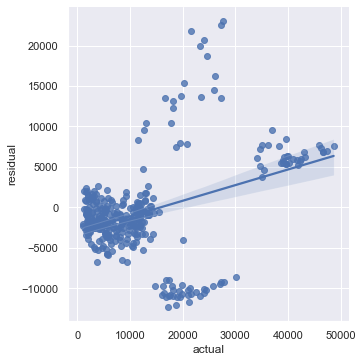

Root Mean Square Error:  5879.891035056813


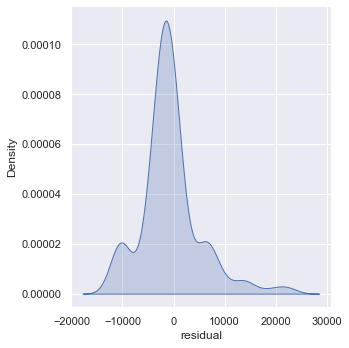

In [52]:
y_pred = est2.predict(sm.add_constant(X_test[[y for x,y in enumerate(inputs) if x not in [3,5,6,7]]]))
preds = y_pred.to_numpy().reshape(len(y_pred),1)
residual_df = pd.DataFrame(np.concatenate([y_test,preds,y_test-preds],axis = 1),columns=['actual','predicted','residual'])
sns.lmplot(x='actual',y='residual',data=residual_df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/residual_df.shape[0]*(residual_df.residual).dot(residual_df.residual)))
sns.displot(residual_df, x="residual", kind="kde", fill=True)

In [1]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(excluded[best_feature])
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(excluded[best_feature], best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        print(worst_pval)
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(X[included].columns[worst_feature], worst_pval))
            included.remove(X[included].columns[worst_feature])
        if not changed:
            break
    return included

inputs=list(encoded_data.columns)
inputs.remove(output_var)
X = pd.DataFrame(X,columns = inputs)
y = encoded_data[[output_var]].to_numpy()
result = stepwise_selection(X, y)
print('resulting features:')
print(result)
X2 = sm.add_constant(X[result])
est = sm.OLS(y, X2).fit()
print(est.summary())

NameError: name 'encoded_data' is not defined

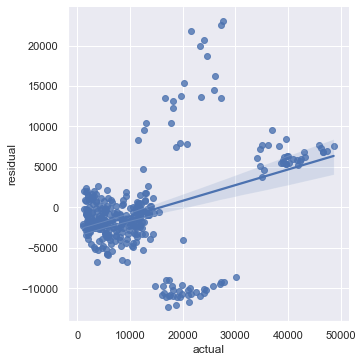

Root Mean Square Error:  5879.891035056813


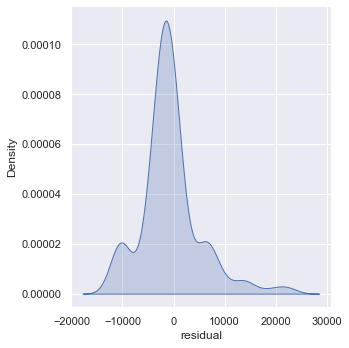

In [54]:
X_test = scaler.transform(pd.get_dummies(x_test, columns=["sex","smoker","region"],drop_first=True))
X_test = pd.DataFrame(X_test,columns = inputs)
y_pred = est.predict(sm.add_constant(X_test[result]))
preds = y_pred.to_numpy().reshape(len(y_pred),1)
residual_df = pd.DataFrame(np.concatenate([y_test,preds,y_test-preds],axis = 1),columns=['actual','predicted','residual'])
sns.lmplot(x='actual',y='residual',data=residual_df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/residual_df.shape[0]*(residual_df.residual).dot(residual_df.residual)))
sns.displot(residual_df, x="residual", kind="kde", fill=True)

In [55]:
import scipy.stats as stats
w, pvalue = stats.shapiro(residual_df.residual)
print(w, pvalue)
residual_df

0.8962719440460205 2.4232938382719518e-14


,actual,predicted,residual
0,9264.79700,7922.182949,1342.614051
1,12096.65120,12315.384746,-218.733546
2,2643.26850,3981.744828,-1338.476328
3,11657.71890,11707.242606,-49.523706
4,34672.14720,29536.531721,5135.615479
...,...,...,...
330,4347.02335,5835.301398,-1488.278048
331,10806.83900,13172.802392,-2365.963392
332,1137.46970,3392.576081,-2255.106381
333,9872.70100,12703.812443,-2831.111443


#### Piecewise linear Regression

##### Model for Non Smokers

In [56]:
list_match = X['smoker_yes'] == 0
no_smoke_X = X.loc[list_match]
no_smoke_X.drop('smoker_yes',axis=1,inplace=True)
y = pd.DataFrame(y,columns=[[output_var]])
no_smoke_y = y.loc[list_match].to_numpy()

result = stepwise_selection(no_smoke_X, no_smoke_y)
print('resulting features:')
print(result)
X2 = sm.add_constant(no_smoke_X[result])
est_no = sm.OLS(no_smoke_y, X2).fit()
print(est_no.summary())

Add  age                            with p-value 4.1959e-97
4.1959001949149496e-97


C:\Users\sarab\Anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\sarab\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  children                       with p-value 0.000122604
0.00012260359132179236
0.00012260359132179236
resulting features:
['age', 'children']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     304.4
Date:                Fri, 12 Feb 2021   Prob (F-statistic):           7.93e-99
Time:                        19:21:54   Log-Likelihood:                -7848.1
No. Observations:                 796   AIC:                         1.570e+04
Df Residuals:                     793   BIC:                         1.572e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.

In [57]:
X_test = scaler.transform(pd.get_dummies(x_test, columns=["sex","smoker","region"],drop_first=True))
print(X_test.shape)
no_smoke_X = pd.DataFrame(X_test,columns = inputs).query("smoker_yes == 0")
print(no_smoke_X.shape)
# no_smoke_X = X_test.loc[list_match]
X2 = sm.add_constant(no_smoke_X[result])
y_pred = est_no.predict(X2)

(335, 8)
(268, 8)


In [58]:
select_y = y_test.iloc[no_smoke_X.index]
print(y_pred.to_numpy().shape,select_y.shape)
preds = y_pred.to_numpy().reshape(len(y_pred),1)
residual_df = pd.DataFrame(np.concatenate([select_y,preds,select_y-preds],axis = 1),columns=['actual','predicted','residual'])

(268,) (268, 1)


In [59]:
residual_df.describe()

,actual,predicted,residual
count,268.000000,268.000000,268.000000
mean,8123.554071,8184.329825,-60.775754
std,5467.999905,3965.360903,4576.388021
min,1136.399400,1867.364992,-2663.399549
25%,3961.133075,4685.249141,-1836.147002
50%,6947.874100,7986.421721,-1379.514824
75%,11315.830663,12011.747927,-749.564606
max,27724.288750,15796.208938,24783.295698


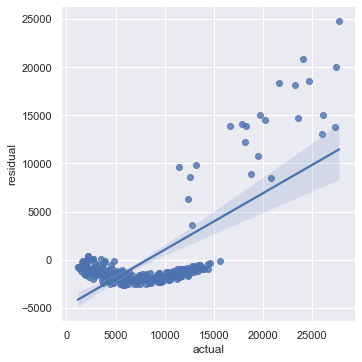

Root Mean Square Error:  4568.246301287338


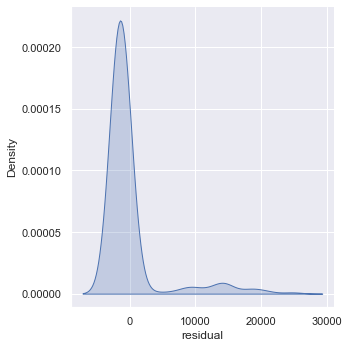

In [60]:
sns.lmplot(x='actual',y='residual',data=residual_df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/residual_df.shape[0]*(residual_df.residual).dot(residual_df.residual)))
sns.displot(residual_df, x="residual", kind="kde", fill=True)

In [61]:
# Testing for Normality - p < 0.05 => Not Normal
w, pvalue = stats.shapiro(residual_df.residual)
print(w, pvalue)

0.45810049772262573 9.594462981852224e-28


##### Model for Smokers

In [62]:
list_match = X['smoker_yes'] == 1
yes_smoke_X = X.loc[list_match]
yes_smoke_X.drop('smoker_yes',axis=1,inplace=True)
y = pd.DataFrame(y,columns=[[output_var]])
yes_smoke_y = y.loc[list_match].to_numpy()

result = stepwise_selection(yes_smoke_X, yes_smoke_y)
print('resulting features:')
print(result)
X2 = sm.add_constant(yes_smoke_X[result])
est_yes = sm.OLS(yes_smoke_y, X2).fit()
print(est_yes.summary())

Add  bmi                            with p-value 3.09133e-47
3.0913349378709187e-47
Add  age                            with p-value 3.94127e-16
3.9412745877291106e-16
3.9412745877291106e-16
resulting features:
['bmi', 'age']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     289.3
Date:                Fri, 12 Feb 2021   Prob (F-statistic):           2.79e-60
Time:                        19:21:56   Log-Likelihood:                -2094.0
No. Observations:                 207   AIC:                             4194.
Df Residuals:                     204   BIC:                             4204.
Df Model:                           2                                         
Covariance Type:            nonrobust                          

C:\Users\sarab\Anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\sarab\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [63]:
X_test = scaler.transform(pd.get_dummies(x_test, columns=["sex","smoker","region"],drop_first=True))
print(X_test.shape)
yes_smoke_X = pd.DataFrame(X_test,columns = inputs).query("smoker_yes == 1")
print(yes_smoke_X.shape)
# no_smoke_X = X_test.loc[list_match]
X2 = sm.add_constant(yes_smoke_X[result])
y_pred = est_yes.predict(X2)

select_y = y_test.iloc[yes_smoke_X.index]
print(y_pred.to_numpy().shape,select_y.shape)
preds = y_pred.to_numpy().reshape(len(y_pred),1)
residual_df = pd.DataFrame(np.concatenate([select_y,preds,select_y-preds],axis = 1),columns=['actual','predicted','residual'])

(335, 8)
(67, 8)
(67,) (67, 1)


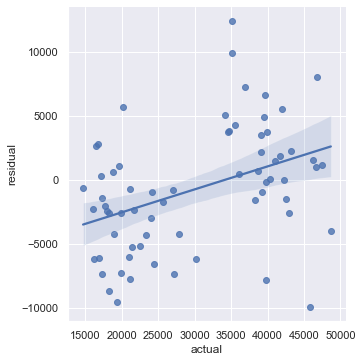

Root Mean Square Error:  4841.269945042583


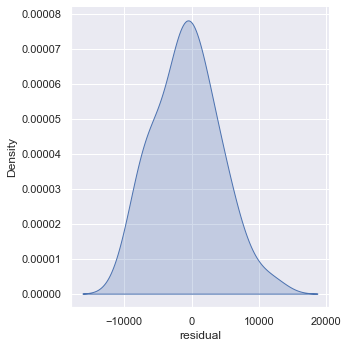

In [64]:
sns.lmplot(x='actual',y='residual',data=residual_df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/residual_df.shape[0]*(residual_df.residual).dot(residual_df.residual)))
sns.displot(residual_df, x="residual", kind="kde", fill=True)

In [65]:
# Testing for Normality - p < 0.05 => Normal
w, pvalue = stats.shapiro(residual_df.residual)
print(w, pvalue)

0.9875156879425049 0.7416197657585144


#### Decision Tree Regressor

In [83]:
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0,max_depth=3)  
  
# fit the regressor with X and Y data 
regressor.fit(X, y) 

DecisionTreeRegressor(max_depth=3, random_state=0)

In [84]:
from sklearn.tree import export_graphviz  
  
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
export_graphviz(regressor, out_file ='tree.dot', 
               feature_names =inputs) 

In [85]:
import os
os.system("cmd C:/Users/sarab/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin/graphviz/dot -Tpng 'C:/Users/sarab/Documents/Python Scripts/sabudh/tree.dot' -o 'C:/Users/sarab/Documents/Python Scripts/sabudh/tree.png'")

0

In [86]:
X_test = scaler.transform(pd.get_dummies(x_test, columns=["sex","smoker","region"],drop_first=True))
y_pred = regressor.predict(X_test) 
  
# print the predicted price 
print(y_pred.reshape(len(y_pred),1).shape,y_test.shape)
preds = y_pred.reshape(len(y_pred),1)
preds.shape
residual_df = pd.DataFrame(np.concatenate([y_test,preds,y_test-preds],axis = 1),columns=['actual','predicted','residual'])

(335, 1) (335, 1)


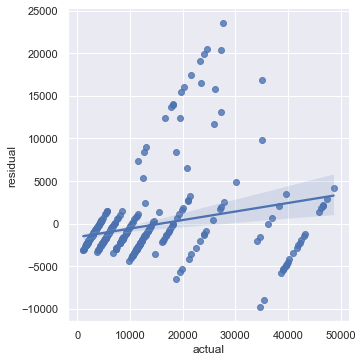

Root Mean Square Error:  4599.609259693091


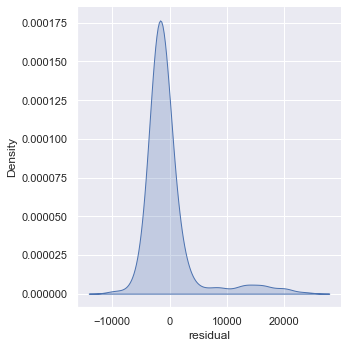

In [87]:
sns.lmplot(x='actual',y='residual',data=residual_df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/residual_df.shape[0]*(residual_df.residual).dot(residual_df.residual)))
sns.displot(residual_df, x="residual", kind="kde", fill=True)

In [71]:
# Testing for Normality - p < 0.05 => Not Normal
w, pvalue = stats.shapiro(residual_df.residual)
print(w, pvalue)

0.6405938267707825 6.03320019126173e-26


#### Nearest Neighbour Regression

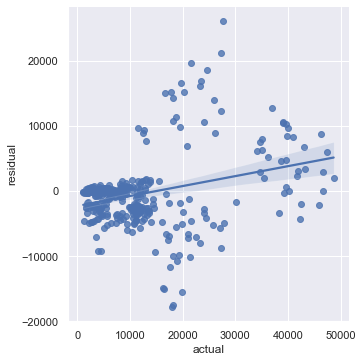

Root Mean Square Error:  5503.148795160211


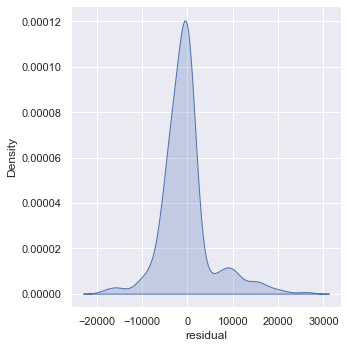

In [85]:
X = encoded_data[encoded_data.columns[~encoded_data.columns.isin([output_var])]].to_numpy()
y = encoded_data[[output_var]].to_numpy()
X = scaler.fit_transform(encoded_data[encoded_data.columns[~encoded_data.columns.isin([output_var])]])

from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)


X_test = scaler.transform(pd.get_dummies(x_test, columns=["sex","smoker","region"],drop_first=True))
y_pred = neigh.predict(X_test)
preds = y_pred.reshape(len(y_pred),1)
residual_df = pd.DataFrame(np.concatenate([y_test,preds,y_test-preds],axis = 1),columns=['actual','predicted','residual'])
sns.lmplot(x='actual',y='residual',data=residual_df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/residual_df.shape[0]*(residual_df.residual).dot(residual_df.residual)))
sns.displot(residual_df, x="residual", kind="kde", fill=True)

#### Ensemble Model

In [86]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X, y)
regr.feature_importances_

C:\Users\sarab\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


array([1.22736265e-01, 1.70524554e-01, 1.01482118e-02, 6.71954427e-04,
       6.93384955e-01, 1.30525368e-03, 6.68425852e-04, 5.60380374e-04])

In [87]:
regr.estimators_[0]

DecisionTreeRegressor(max_depth=5, max_features='auto', random_state=209652396)

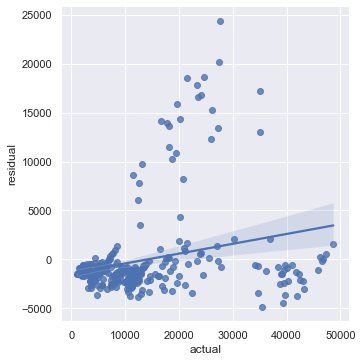

Root Mean Square Error:  4320.167713554186


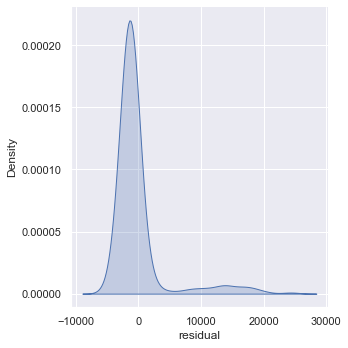

In [88]:
X_test = scaler.transform(pd.get_dummies(x_test, columns=["sex","smoker","region"],drop_first=True))
y_pred = regr.predict(X_test)
preds = y_pred.reshape(len(y_pred),1)
residual_df = pd.DataFrame(np.concatenate([y_test,preds,y_test-preds],axis = 1),columns=['actual','predicted','residual'])
sns.lmplot(x='actual',y='residual',data=residual_df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/residual_df.shape[0]*(residual_df.residual).dot(residual_df.residual)))
sns.displot(residual_df, x="residual", kind="kde", fill=True)

In [89]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0,min_samples_split=4)
reg.fit(X, y)

C:\Users\sarab\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(min_samples_split=4, random_state=0)

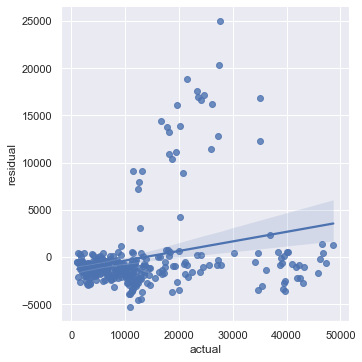

Root Mean Square Error:  4295.949603663442


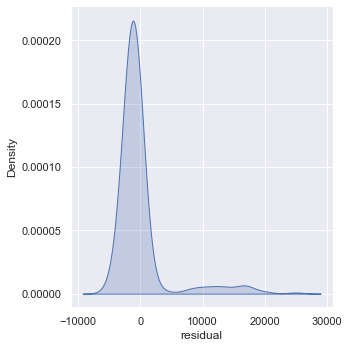

In [90]:
X_test = scaler.transform(pd.get_dummies(x_test, columns=["sex","smoker","region"],drop_first=True))
y_pred = reg.predict(X_test)
preds = y_pred.reshape(len(y_pred),1)
residual_df = pd.DataFrame(np.concatenate([y_test,preds,y_test-preds],axis = 1),columns=['actual','predicted','residual'])
sns.lmplot(x='actual',y='residual',data=residual_df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/residual_df.shape[0]*(residual_df.residual).dot(residual_df.residual)))
sns.displot(residual_df, x="residual", kind="kde", fill=True)

In [91]:
reg.feature_importances_

array([0.12261068, 0.1778843 , 0.01027593, 0.00092894, 0.68478905,
       0.00131731, 0.00132445, 0.00086934])

In [92]:
reg.estimators_[0][0]

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      min_samples_split=4,
                      random_state=<mtrand.RandomState object at 0x000001CEB54002D0>)

In [93]:
export_graphviz(reg.estimators_[0][0], out_file ='tree.dot', 
               feature_names =inputs) 

#### Support Vector Regression

In [94]:
from sklearn.svm import SVR
regr = SVR(C=10000.0, epsilon=0.001,kernel='poly',degree=3)
regr.fit(X, y)

C:\Users\sarab\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVR(C=10000.0, epsilon=0.001, kernel='poly')

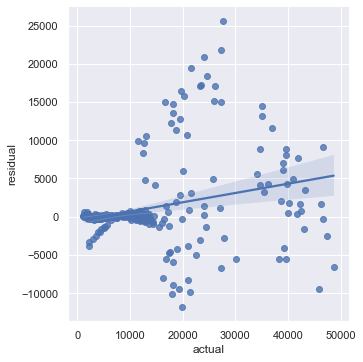

Root Mean Square Error:  4927.225042780123


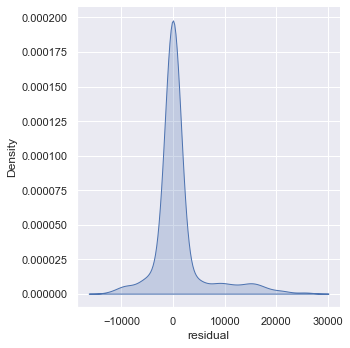

In [95]:
X_test = scaler.transform(pd.get_dummies(x_test, columns=["sex","smoker","region"],drop_first=True))
y_pred = regr.predict(X_test)
preds = y_pred.reshape(len(y_pred),1)
residual_df = pd.DataFrame(np.concatenate([y_test,preds,y_test-preds],axis = 1),columns=['actual','predicted','residual'])
sns.lmplot(x='actual',y='residual',data=residual_df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/residual_df.shape[0]*(residual_df.residual).dot(residual_df.residual)))
sns.displot(residual_df, x="residual", kind="kde", fill=True)